In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk import tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression

tqdm.pandas()

np.random.seed(42)
random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 50.9 MB/s eta 0:00:0000:0100:01


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Предобработка данных

Сперва попробуем извлечь из текста всё, что только можно. Фактически здесь всё то же, что и в бейзлайне, но с парой небольших отличий

In [21]:
df = pd.read_csv("/kaggle/input/ilovepudge/train_ml.csv")

В датасете есть пропуски, но я понятия не имею, как их использовать. Проблема в том, что это пропуски в таргете, обычная стратегия замены - через импутер - тут сработает так себе. Я пробовал и со средним, и с медианой, так или иначе качество сильно падает, видимо, из-за дисбаланса классов. Я пробовал предсказывать таргеты по лусшей модели, обученной на данных без пропусков, снова безрезультатно. Поэтому мы от них просто избавимся. Грустно, наверное, что-то всё-таки сделать можно

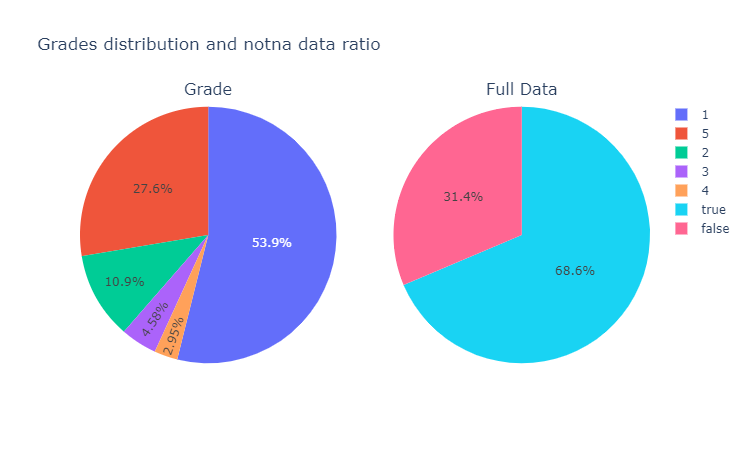

In [50]:
from plotly.subplots import make_subplots

sub_df = df["grades"].value_counts()
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=["Grade", "Full Data"])
fig.add_trace(go.Pie(labels=sub_df.index, values=sub_df.values,
                     name="Grade"),
              row=1, col=1)
fig.add_trace(go.Pie(labels=df.grades.notna().unique(),
                             values=df.grades.notna().value_counts(),
                     name="Full data"),
              row=1, col=2)
fig.update_layout(title_text="Grades distribution and notna data ratio")
fig.show()

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df.dropna()
y = df["grades"].reset_index(drop=True)
X = df.drop("grades", axis=1).reset_index(drop=True)
X_test = pd.read_csv("/kaggle/input/ilovepudge/new_test_ml.csv")

Теперь надо токенизировать текст. Здесь пришла в голову только одна мысль - отделить ещё и пунктуацию со смайликами, всё-таки они тоже могут выражать какие-либо эмоции. Я пробовал использовать `TweetTokenizer`, оказалось бесполезно, так что здесь решение из бейзлайна    
Стемминг я не пробовал. Скорее всего получится жижа, потому что в русском языке по одной основе что-то сказать трудно, но кто знает    
**Что важно** - я не стал фильтровать стоп-слова. Почему-то оказывается, что они тоже довольно важны. Как минимум там есть частица "не", которая может на тональность повлиять кардинально

In [4]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

def lemmatize(df):
    with Pool(4) as p:
        lemmas = list(tqdm(p.imap(clean_text, df['feeds']), total=len(df)))
    df['lemmas'] = lemmas
    return df

Далее - части речи тоже что-то говорят о тональности текста, хотя казалось бы. Адекватных варианта тут 2 - `pymorphy` и `mystem`. Второй точнее, дольше работает и учитывает контекст. Оба были созданы с использованием нейросеток, поэтому изначально я не хотел их юзать. С другой стороны, в подсказках к соревнованию, pos-tagging предлагается в явном виде, так что я надеюсь, что всё легитимно. В любом случае я никаую архитектуру не строю и не обучаю

In [5]:
%%capture
!pip install pymystem3
from pymystem3 import Mystem
from collections import Counter

In [8]:
def get_pos(df):

    m = Mystem()
    mystem = []

    for text in tqdm(df.feeds):

        ana = m.analyze(text)
        poss = Counter()
        for word in ana:
            if 'analysis' in word:
                if word["analysis"]:
                    gr = word['analysis'][0]['gr']
                    pos = gr.split('=')[0].split(',')[0]
                    poss[pos] += 1
                else:
                    poss["nan"] += 1
        mystem.append(poss)
        
    return pd.DataFrame(mystem)

Осталось извлечь длины отзывов. Я считал отдельно и для лемм, и для полных текстов, как бы длина релевантной и нерелевантной части. Это очень важные параметры. Как правило, длинные отзывы имеют более негативный окрас, людям хочется выговориться. Соответственно, качество растёт очень неплохо. К тому же они пригодятся, когда будем придумывать новые фичи

In [6]:
def get_lens(df):
    df['sym_len'] = df.feeds.apply(len)
    df['lemma_sym_len'] = df.lemmas.apply(len)
    df['word_len'] = df.feeds.apply(lambda x: len(x.split()))
    df['lemma_word_len'] = df.lemmas.apply(lambda x: len(x.split()))
    return df.drop("feeds", axis=1)

In [9]:
pos, pos_test = get_pos(X), get_pos(X_test)
X, X_test = lemmatize(X), lemmatize(X_test)
X, X_test = get_lens(X), get_lens(X_test)

100%|██████████| 17220/17220 [03:18<00:00, 86.92it/s] 


Остаётся вопрос - что делать с дисбалансом классов? Есть вариант с аугментацией текстов - я не пробовал, может помочь. Есть вариант с синтетическим расширением выборки через `SMOTE` - работает плохо. Поэтому принято решение оставить их в покое. Выбросы я не анализировал и не убирал, может быть, они есть, и это как-то поможет

## 2. Feature Engineering

Прежде чем фичи анализировать, давайте создадим ещё парочку, которые себя очень зарекомендовали. Для начала обзорный список того, что может и не может помочь:

#### 1. Dict-based features
Это фичи, которые получаются из составления словаря отзывов. Мы берём слова строго позитивные/нейтральные/..., которые встречаются только в соответствующих отзывах, фильтруем их, потому что большая их часть мусорные, что-то типа стоп слов, и пихаем в модель. Всё просто и, как ни странно, показывает себя неплохо

- ##### Negativity
Признак того, насколько отзыв негативный. Берём n самых частых уникальных негативных слов, берём разность со множеством позитивных слов и вуаля. Чем более отзыв негативный, тем большё в нём должно быть таких слов - просто считаем их в каждом отзыве. В идеале - в позитивных отзывах 0 (на трейне соблюдается), на негативных - вплоть до 100. Работает хорошо, помогает обучаться
- ##### Positivity and Neutrality
Симметричные признаки для позитивных и нейтральных отзывов (оценка от 2 до 4). Здесь уже гораздо хуже. Почему-то выражать своё недовольство народ умеет гораздо красочнее. Позитивные слова всё-таки оказываются частыми вообще везде, даже в негативных отзывах, нерепрезентативный признак. Нейтральных попросту слишком мало из-за дисбаланса классов. Логарифм не помогает. В помойку.

#### 2. Date features
Дата, как мы знаем, довольно полезна сама по себе.

- ##### Year
Вполне вероятно, что в какой-то год люди в целом добрее, в какой-то - злее, например, из-за кризиса или небезывестных событий. Звучит, конечно, прохладно, но пока оно работает, я не задаю лишних вопросов

- ##### Day
Скорее всего юзлесс, даже не стал пробовать

- ##### Month
Та же логика, что и с годом. Может быть, к Новому Году или на летних каникулах люди добреют?

- ##### Hour
Его я тоже брал, но на счёт его полезности в принципе сомневаюсь. По крайней мере я по утрам вообще очень злой, может быть, это так работает

- ##### Dow

#### 3. Paired features
Попытка построить новый признак, как упорядоченную пару других. Может сработать, если между ними есть нелинейная зависимость

- ##### Bank and year
Я пробовал только одну фичу, больше идей у меня нет. Вполне возможно, что банки в разные года имели разное качество обслуживания, это можно попробовать учесть. Получилось почему-то так себе, хотя мысль, мне кажется, очень светлая

#### 4. Feature transformation
Многие фичи имеют длинные хвосты. Испытывая вьетнамские флешбеки из дз2, есть мысль, что исправив это, качество можно поднять. Также вполне возможно, что некоторые признаки сильно скоррелированы друг с другом, можно попробовать на это повлиять

- ##### Log lens
Брать логарифмы от длин текстов - это очень и очень плохая мысль. Не знаю, почему но качество падает просто разительно, лучше их не трогать
- ##### Log mean negativity
Сама по себе негативность считалась абсолютно, нам бы скорее хотелось посчитать её среднее, иначе она будет прямо зависеть от длины отзыва. Это первый момент. Далее, у неё опять же очень длинный хвост, логарифм делает распределение более равномерным, и это неплохо бустит качество. Оставляем
- ##### Mean pos count
Части речи испытывают аналогичную проблему, что и логарифм негативности. Лучше брать сразу среднее. Логарифм я тоже пытался взять, но это просто не влияет никак

#### 5. Clusterization
Кластеризация вообще не особо помогает. Я пробовал только `MiniBatchKMeans`, остальные плохо работают с разреженными матрицами. В общем никак не влияют на скор, всё же мы не совсем вправе сравнивать разные векторы и составлять кластеры. Даже деление на положительный и отрицательнйы отзыв во многом зависит от человека, который этот отзыв написал, а не от собственно характеристик слова

#### 6. Text Augmentation
Я изначально скептически к этому относился, но всё же немного попробовал.

- ##### Синонимы
Во-первых, синоним это очень расплывчатая формулировка, абсолютно одинаковых слов не бывает (почти), нюансы в семантика есть. Во-вторых, тональность всё-таки определяется не одним словом, а их комбинацией, единичная замена вряд ли что-то исправит, это не будет совсем новый объект. У меня что-то не получилось найти нормальных библиотек для русского, так что я сделал кастомную функцию. Она анализирует "ruwordnet", ищет оттуда синонимы, вытаскивает рандомные, заменяет нужную долю слов в тексте, добавляет в выборку. Получилось не очень

- ##### Обратный перевод
Я на самом деле так и не вставил. У меня есть внизу ячейки, которые это делают, но качество перевода, мягко говоря, не воодушевляет. Можно попробовать, скорее всего будет плохо

In [ ]:
%%capture
!pip install nlpaug
!pip install wiki-ru-wordnet

In [ ]:
from itertools import chain
from wiki_ru_wordnet import WikiWordnet
wikiwordnet = WikiWordnet()


def get_candidates(word):
    synsets = wikiwordnet.get_synsets(word)
    raw = list(set(chain.from_iterable([x.get_words() for x in synsets])))
    synonyms = [x.lemma() for x in raw]
    return np.random.choice(synonyms, 1)[0] if synonyms else word

def custom_augment(text, aug_max=0.5):
    words_to_augment = np.random.choice(text.split(), int(len(text.split())*aug_max))
    func = np.vectorize(get_candidates)
    candidates = np.vectorize(get_candidates)(words_to_augment)
    for i in range(candidates.size):
        text = text.replace(" "+words_to_augment[i]+" ",
                            " "+candidates[i]+" ")
    return text


In [11]:
import nlpaug.augmenter.word as naw

text = 'Ну давай разберем по частям тобою написанное'
back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-ru-en', 
    to_model_name='facebook/wmt19-en-ru'
)
back_translation_aug.augment(text)

['Что ж, давайте разберемся.']

#### Postscriptum
Постфактум хочется заметить, что нейтральность и позитивность на самом деле не мусорные признаки, предсказание с ними оказалось моим самым лучшим на приватном датасете, но я этого никак предугадать не мог. Обидно, конечно, хотя топ-3 ладдера тоже наплохо, но да, надо было сразу делать нормальную валидацию. Я уже давно их выбросил из своей модели, можно их обучить заново, `get_sentimentality` несложная функция, по идее дефолтные параметры должны дать тот же результат. Сейчас у меня их нет, построить я их не смогу
#### Postpostscriptum
Я вот сейчас строил графики и заметил одну смешную вещь. Я неправильно написал негативный фильтр, когда засовывал его в функцию, он стал выглядеть, как {"н", "е"} - подсчитывал логарифм среднего этих букв. Любопытно, что это даёт прирост качества. Модель без такого псевдо `"log_negativity"` даёт качество хуже. Смешно. Сейчас я всё поправил, надо запустить ещё раз, качество может улучшиться. Для целей проверки моего решения поставил заглушку в виде `pseudo_filter`

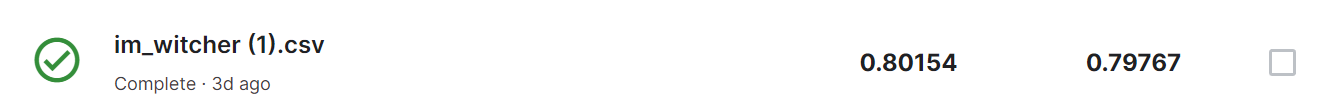

In [3]:
from IPython.display import Image
Image(filename='/kaggle/input/ilovepudge/best_feature_combination.png')

Теперь давайте это всё закодим

!!! **добавить комменты к функциям** !!!

In [10]:
def convert_date(df):
    df['date'] = pd.to_datetime(df.date)
    df['hour'] = df.date.dt.day
    #data['day'] = data.date.dt.day
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df["dow"] = df.date.dt.weekday
    return df.drop("date", axis=1)

def get_sentimentality(df, dict_filter, sentiment="negativity"):
    df[sentiment] = df["lemmas"].progress_apply(lambda x: x.split())
    df[sentiment] = df[sentiment].progress_apply(lambda x: sum(i in x for i in dict_filter))
    df[f"log_{sentiment}"] = np.log1p((df[sentiment] / df["word_len"]))
    return df.drop(sentiment, axis=1) 

def transform_pos(pos_df, df):
    pos_df = pos_df.apply(lambda x: x / df["word_len"]).fillna(0)
    return pd.concat([pos_df, df], axis=1)

Фильтры для негативности я доставал ручками из обучающей выборки. Наверное, можно было бы сделать отдельный трансформер, если ещё когда-нибудь буду заниматься NLP без сеток - сделаю обязательно. Можно поподбирать размеры словаря, как выяснилось, это довольно важно

In [10]:
%%time
tqdm.pandas()

neg_reviews = X[y.values == 1]["lemmas"].sum()
print("")


CPU times: user 7min 58s, sys: 12min 56s, total: 20min 54s
Wall time: 20min 39s


In [11]:
%%time
pos_reviews = X[y.values == 5]["lemmas"].sum()
print("")


CPU times: user 25.8 s, sys: 248 ms, total: 26.1 s
Wall time: 25.7 s


Под конец сделал ошибку, написал выше. Чтобы воспроизвести последнюю модель, фильтр должен быть именно такой

In [11]:
pseudo_filter = {"н"}

Ячейкой ниже можно достать самые частые слова по тональности, по хорошему надо тоже засунуть в функцию, мне уже как-то лень

In [ ]:
neg_vocab = Counter(neg_reviews.split()).most_common(2000)
neg_vocab = {x[0] for x in neg_vocab if x[0] not in mystopwords and len(x[0]) > 3}
pos_vocab = Counter(pos_reviews.split()).most_common(1000)
pos_filter = {x[0] for x in pos_vocab if x[0] not in neg_vocab and x[0] not in mystopwords and len(x[0]) > 3}

In [278]:
X, X_test = get_sentimentality(X, pseudo_filter), get_sentimentality(X_test, pseudo_filter)

100%|██████████| 17220/17220 [00:00<00:00, 130241.92it/s]


Код выше можно оптимизировать, засунуть в функции, сделать, чтобы он считал позитивность, нужно только заменить пару переменных, но как я уже сказал, это только вредит модели, я пробовал. А как говорит уже будущий я, это наоборот, помогает, стоит попробовать

In [16]:
X, X_test = convert_date(X), convert_date(X_test)
X, X_test = get_sentimentality(X, pseudo_filter), get_sentimentality(X_test, pseudo_filter)
X, X_test = transform_pos(pos, X), transform_pos(pos_test, X_test)

100%|██████████| 17220/17220 [00:00<00:00, 152417.79it/s]


## 3. EDA

На самом деле большая нужная часть уже была сделана в бейзлайне, абсолютно все распределения имеют большой хвост, кроме одной фичи, она в конце. Соответственно, все выводы по ним одниаковые. Когда-нибудь потом дополню этот раздел, сейчас нет времени

In [14]:
import warnings
import matplotlib as mpl
warnings.simplefilter(action='ignore', category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

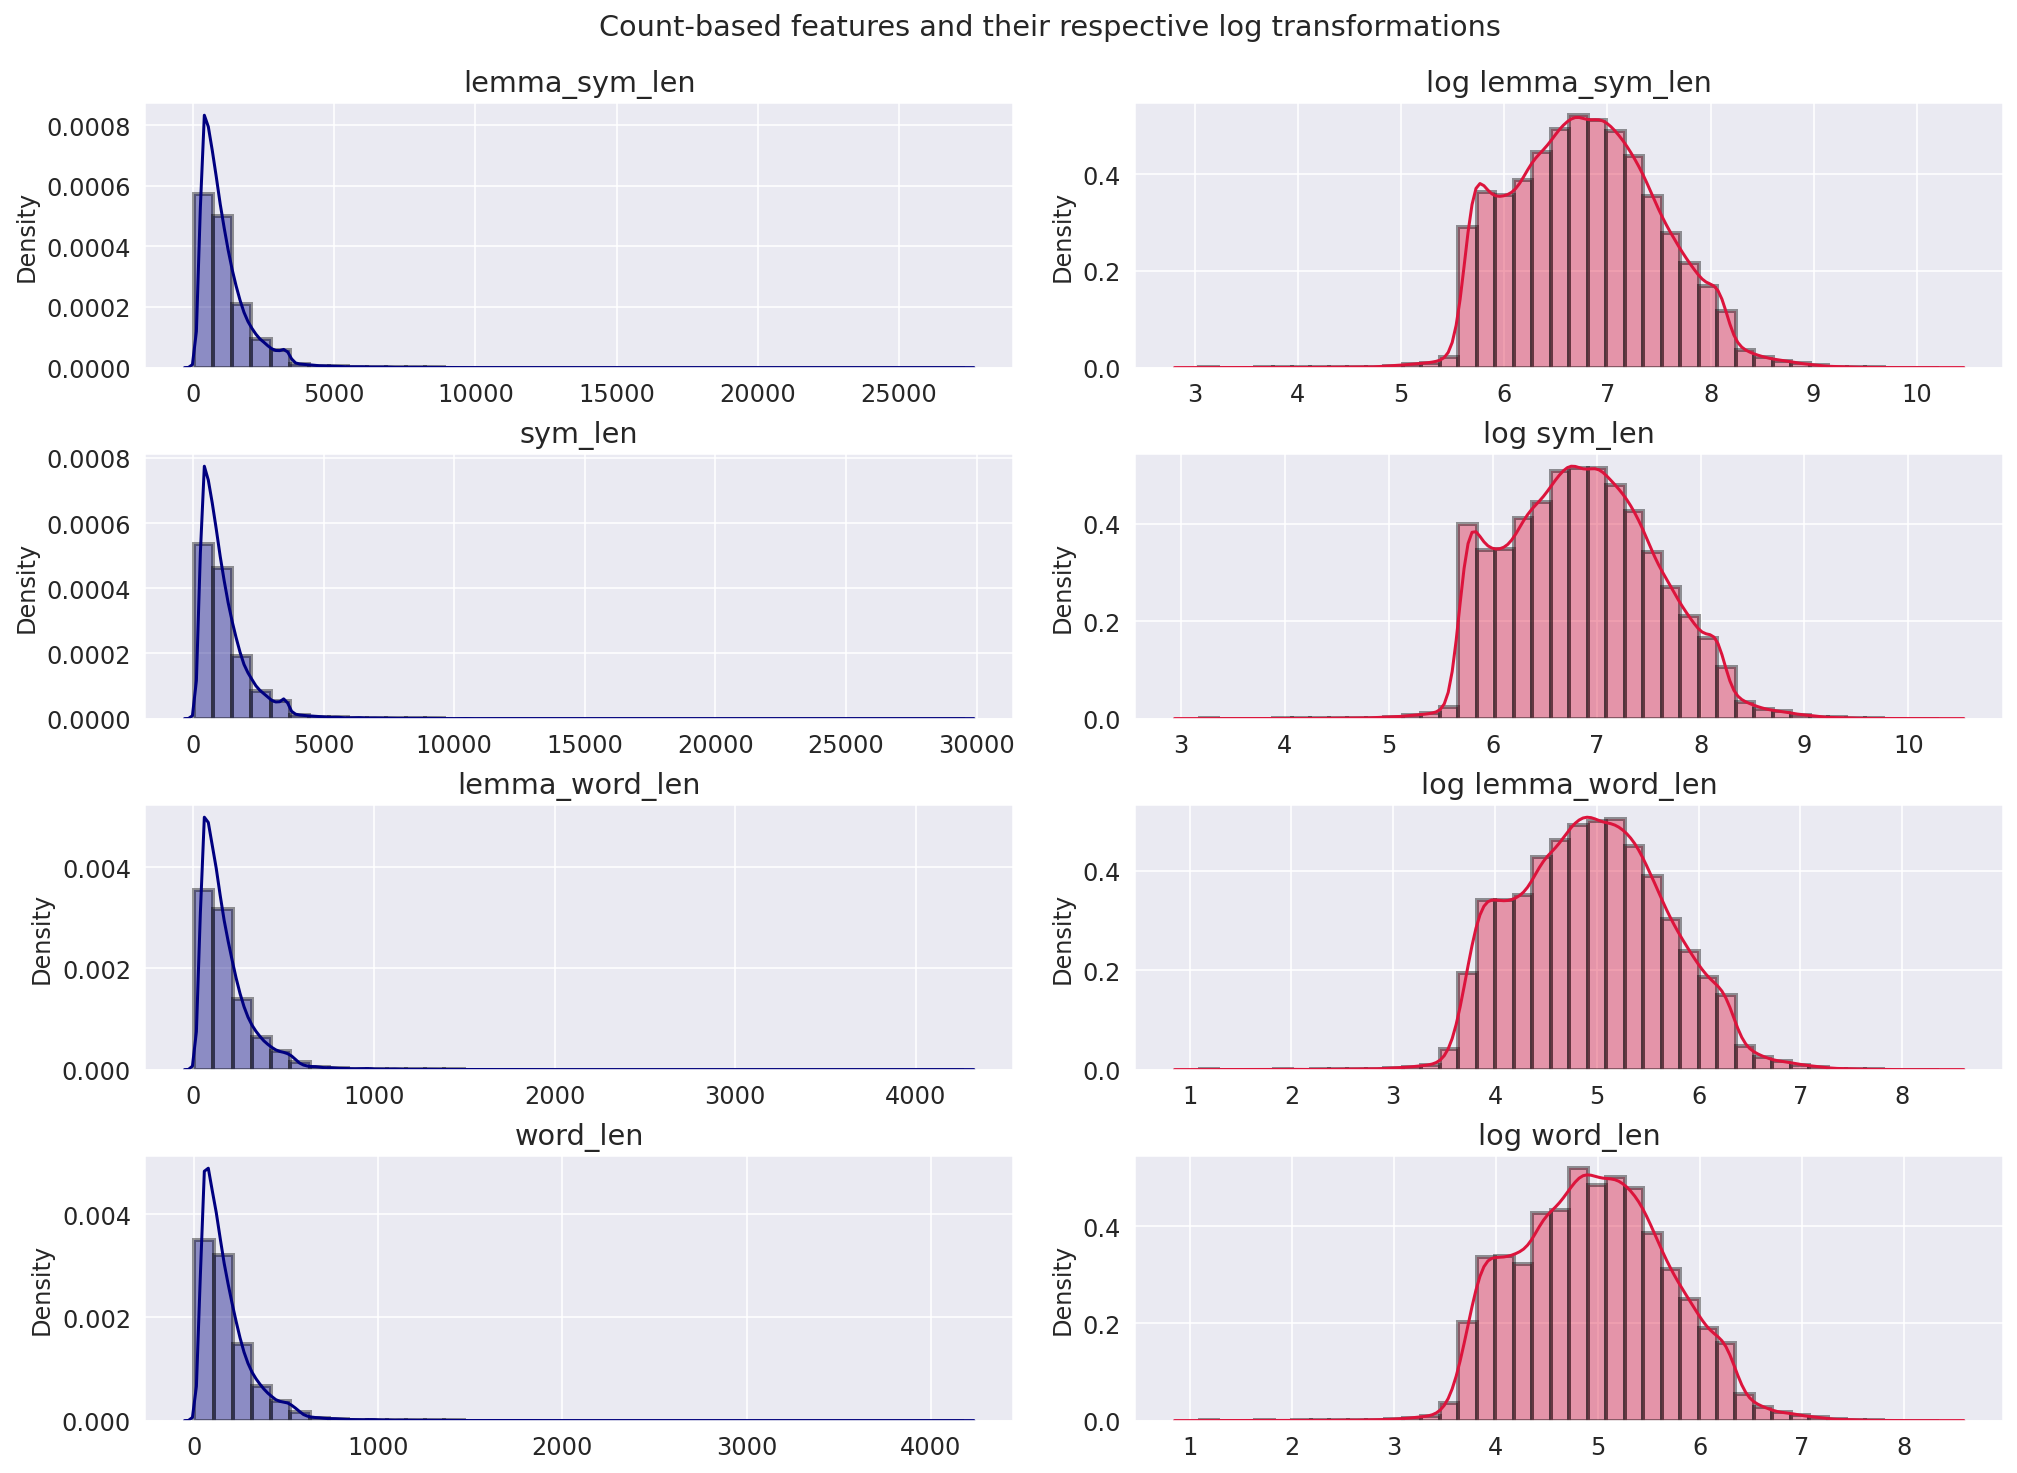

In [143]:
cols = ["lemma_sym_len", "sym_len", "lemma_word_len", "word_len"]

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14, 10))
fig.tight_layout(pad=1.5)

for i, ax in zip(range(4), zip(axes.flat[::2], axes.flat[1::2])):
    sns.distplot(X[cols[i]], ax=ax[0], bins=40,
                 hist_kws=dict(edgecolor="k", linewidth=2),
                 color="navy")
    ax[0].set_title(cols[i])
    ax[0].set(xlabel=None)
    sns.distplot(np.log(X[cols[i]]), ax=ax[1], bins=40,
                 hist_kws=dict(edgecolor="k", linewidth=2),
                 color="crimson")
    ax[1].set_title("log " + cols[i])
    ax[1].set(xlabel=None)
plt.suptitle("Count-based features and their respective log transformations", y=1.03)
plt.show()

Дальше я хотел показать, что фича `bank_year` могла бы быть полезной, ещё бы вспомнить, какой это был сабмишн в соревновании

In [191]:
sub_df = X[X["bank"].isin(X["bank"].value_counts()[:7].index)]
sub_y = y[sub_df.index]

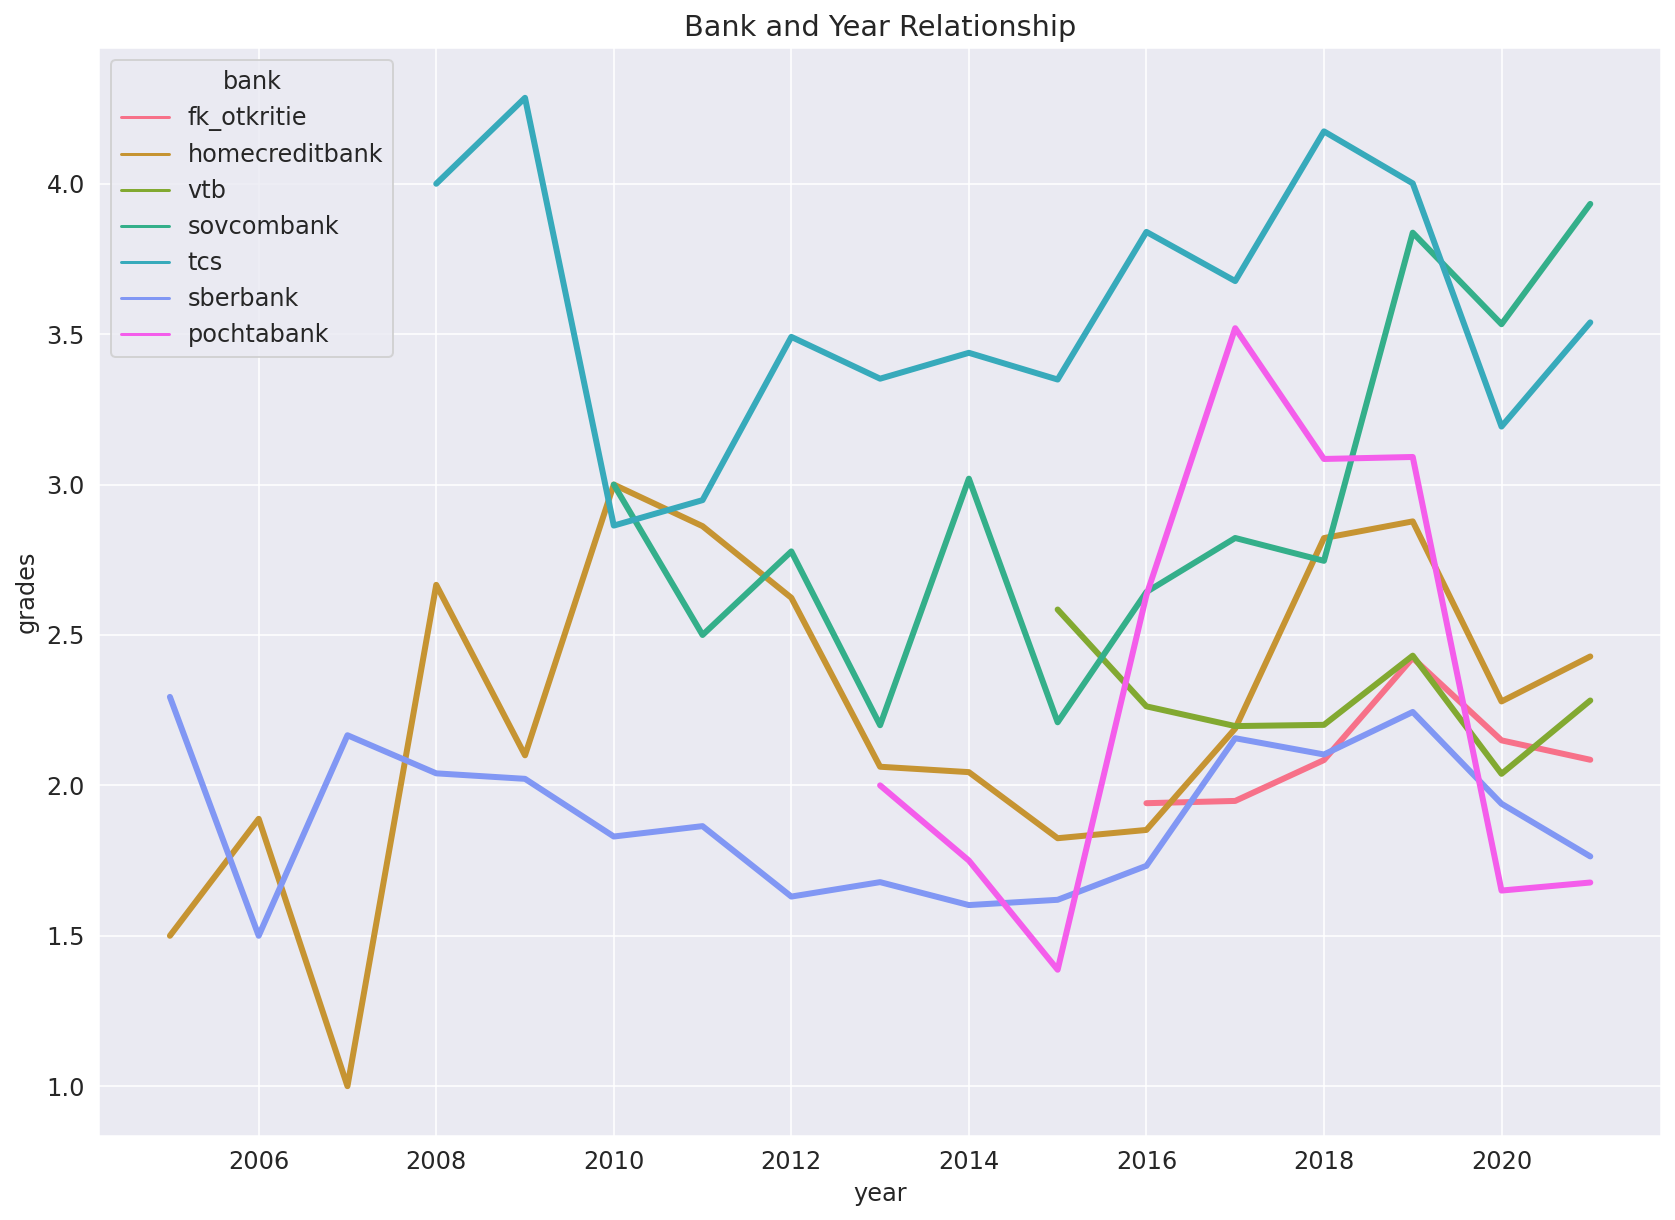

In [196]:
fig, _ = plt.subplots(figsize=(14, 10))
sns.lineplot(x="year", y=y, hue="bank", data=sub_df, ci=None,
             palette=sns.color_palette("husl", 7), linewidth=3)
plt.title("Bank and Year Relationship")
plt.show()

Видно, что у всех банков бывали лучшие и худшие года, оценка разнится сильно. Должно помочь, но не помогает

## 4. Делаем модель 

Теперь у нас уже есть всё, что нужно, осталось найти топовую модель. Как предобработаем данные?

1. Числовые фичи. С ними лучше вего справится `MaxAbsScaler`. У нас очень разреженная матрица, надо этим пользоваться. Стандартизация это нарушит, для таких матриц есть скалер специальный
2. Категориальные фичи. Тут только OHE. У нас их не так много, чтобы использовать mean-target, лучше не терять никакой информации, если это возможно
3. Текстовые фичи. От выбора векторайзера зависит лучшая модель. Для BOW лучше всего работает `MultinomialNB`, f1-score около 0.8 на валидации, для Tfidf - `LinearSVC`, около 0.82. Но подробности ниже. Я в итоге использовал Tfidf, никак не менял в нём дефолтные параметры, а может быть, зря. Брал биграммы - на большем числе фичей просто сильно меньше качество. Размер матрицы для нас не проблема, покуда она разреженная
4. KBest. Так выходит, что некоторые фичи всё-таки ухудшают качество итоговой модели. Очевидно, их нужно как-то выкинуть. SFS работает бесконечно долго, LASSO я не доверяю, остаётся считать статистики. Нормально будет оставить где-то 90% фичей. А ещё это очень важно для бустинга и леса, на 3kk фичах они обучаются очень долго. `PCA` к сожалению крашнет ноутбук - слишком много фичей, так что на него тоже полагаться не стоит

In [17]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [18]:
text = "lemmas"
categorical = ["bank", 'hour', "year"]
numeric = (["sym_len", "word_len"] +
           ['V', "S", 'APRO', 'PR', 'SPRO', "A",
            'ADVPRO', 'PART', 'INTJ', 'ANUM', 'COM'] +
            ["log_negativity"])

tfidf_preprocessor = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(drop="first",
                              handle_unknown="ignore"), categorical),
        ("normalize", MaxAbsScaler(), numeric),
        ("vectorize", TfidfVectorizer(ngram_range=(1, 2), max_df=.625), text)
    ],
    remainder="passthrough"
)

Чтобы было легче проверять, я оставил только те фичи, которые использовал в послендем сабмишне. Тут тоже можно поэкспериментировать, у меня ниже есть условные важности фичей, можно опираться на них

In [ ]:
X = X.drop(["month", "CONJ", "lemma_word_len", "lemma_sym_len", "ADV"], axis=1)

Как же нам теперь выбрать лучшую модель? Вообще это было первое, что я сделал. Сперва я обучил все модели с дефолтными параметрам на валидационной выборке. Правда, я забыл, какой там был сид, но нам всё равно нужно лишь одну вещь понять из этой таблицы

| Model      | Val Score | Time | Review
| ----------- | ----------- | ---------- | ----
| LinearSVC     | 0.83 | ~2min | Самый лучший, самый быстрый, самый красивый
| LogReg   | 0.824 | ~8min | Отстаёт по качеству от LinearSVC. Сложно тюнить. Даёт вероятности, если хочется исправить проблемные объекты ручками - например, заполнить пропуски в таргете. Мне этим заниматься лень. А ещё он учится долго, но если взять solver="sag", будет плюс-минус, как топ1. Точности это ему, впрочем, не добавляет
| SGDClassifier | 0.822 | ~2min | Вроде бы должен быть SGD реализацией линейных регрессий, но по факту всегда отстаёт по качеству, не знаю, почему.
| CatBoost | 0.81 | ~40min | Учится безумно долго, жрёт всю свободную память, очень сложно тюнить, но возможностей много. По итогу даже не даёт нормального качества
| MultinomialNB | 0.802 | ~0s? | Лучший классификатор на BOW. Даёт вероятности, причём в его предсказаниях дисбаланс классов гораздо мягче, чем у линейных методов. Может быть, если его засунуть в ансамбль, покажет себя очень хорошо, я так и не смог его пристроить, но не отметить не могу. А ещё учится моментально, но как его тюнить, я вообще не пон
| RandomForest | 0.8011 | ~15min | Брат-близнец бустинга. Так же плох для этой задачи по тем же причинам
| KNN | 0.7744 | ~2min | Конкретно для классификации вообще плохой. Может быть, можно с его помощью сделать кластеры, сам по себе meh..
| SVC | 0.52 | ~5min | SVM с другими ядрами показывает себя печально. Нет даже смысла его пробовать, самый худший классификатор евер

Уже мы видим, что `LinearSVC` это просто пушка и уделывает даже хвалёный градиентный бустинг. Из всех прочих к нему может подобраться только затюненный LogReg и `SGDClassifier`. Ансамбли, к сожалению, ничего не дают. Можно выбрать буквально какие-то копейки, еслм совместить `LinearSVC` и `LogisticRegression`, но только на валидации. Зато обучается это заметно дольшн

Ниже есть мои заметки, но они довольно беспорядочны. Там есть вся инфа, какие я преобразования делал, и как это повлияло - очевидно, я не сразу пришёл к идее использовать `KBest`, `MaxAbsScaler` и всё прочее. Там же я отслеживал, как мои новые фичи влияют на результат. Единственная загвоздка - у меня сначала была другая валидационная выборка без `stratify`, на ней скоры больше. На новой честной выборке у меня все скоры ниже 0.8 и это ок

In [ ]:
"""
Non-validated
median imputer
LogReg full pipeline - 0.8241466666666667, 0.777
LogReg full pipeline 1000000 best, max_iter 500 - 0.8476133333333333
SVC full pipeline 1000000 best, max_iter 500 - 0.99596

Validated
full pipeline 1000000 best
LogReg, max_iter 500 - 0.824
SVC, max_iter 500 - 0.8254666666666667
SVC, +MaxAbsScaler - 0.8259333333333333
SVC, +ovo - 0.8258000000000001
SVC kernel, ovo - ochen dolgo...
SVC + loss="hinge" - 0.8281333333333334 
SVC + intercept_scaling=0.01 - 0.8284
SVC - no stopwords - 0.8298
SVC - 1.5e06 best - 0.83006
SVC - dropna - - 0.79767 on val - 0.7960
SVC with negativity - 0.79837 - on val - 0.7956 !!!
SGDClassifier - 0.8222

Пытался преобразовать негативити - бесполезно?

Stacking - LogReg, SVC, KNeighbors - 0.8260666666666666
RandomForest, n=100 - 0.796
RandomForest, CountVectorizer, n=100 - 0.795
RandomForest, CountVectorizer, n=200 - 0.7954
RandomForest, CountVectorizer, n=100, max_features=1000 - 0.8011

Stack(LogReg, SVC) - 0.8284 - 0.78772
Stack(LogReg, SVC, RF) - 0.7928

Новый бейзлайн - OvO LinearSVC + negativity + tfdf_preprocessing + dropna + bigram 
0.7930264180264179
replace negativity with log_negativity
0.7933177933177933
negativity and log_negativity
0.7934149184149184
tfidf 3grams
0.788
tfidf 4grams
0.786
tfidf only 2grams
0.750
adding POS count gives nothing?
POS means
0.7925
+ tweet_tokenizer
0.7929292929292929
no POS, positivity and neutrality
0.7926379176379177
log_lens
0.7924
LogReg
0.7869
SVC - L1 Penalty, squared_hinge, dual=False, best so far?
0.7931235431235432
SVC - C=0.85
0.794337296037296
tuned tf-df
0.7964
SynonymAUG
0.7946

KNN tuning:

BOW
5 - 0.7444
20 - 0.7692
45 - 0.7744
70 - 0.7745

TFIDF
5 - 0.70
25 - 0.732
85 - 0.7086
"""

Наконец, осталось только затюнить `LinearSVC`, чтобы всё было максимально красиво. Я перебирал отдельными сетками на фиксированной отложенной выборке, потому что иначе ну слишком долго ждать, даже с `LinearSVC`. Другие модели я тоже пробовал подправить, но без толку:

1. Intercept_scaling. Он показывал стабильно лучшее результаты, чем меньше скейлинг. Видимо, оно нам не нужно, потому что у нас уже все данные отноримрованы, так что я в итоге совсем его убрал.
2. Loss and penalty. Самый стандартный лосс нам не подходит, может быть из-за выбросов. Всё-таки хвосты у некоторых фичей очень уж большие, но выкидывать я их не вижу смысла. Это действительно вполне себе качественные объекты, которые действительно очень длинные, и которые желательно тоже предсказывать, поэтому от выбросов я не чистил. Это может сделать жизнь лучше, но так вышло, что я с самого начала настраивал модель с их учётом, уже подзновато. Касательно параметров SVM, собственно тут всего три варианта комбинации таких параметров, я просто перебрал и взял лучший
3. C. Если сделать регуляризацию самую малость сильнее, станет чуть по лучше. Перебирал по равномерной сетке
4. Decision_function_shape. OVR или OVO? Формально такого параметра нет, но можно добавить через `OneVsOneCLassifier`. Несмотря на благие намерения - отделить нейтрально-позитивные отзывы от нейтральных и всё такое - просто работает хуже OVR
5. Max_iter. Чем нежнее мы сходимся, тем больше нам надо итераций. Я обычно всё тестил на 500 итерациях, тогда всё просто работает очень быстро. Для теста специально воткнул 5000, чтобы всё точно сходилось до конца. Но вполне может иметь смысл early stopping, на валидации это давало плюс качество, но не на тесте

#### Пару слов про ансамбли
1. Беггинг. У линейных моделей смещение и так довольно низкое, делать беггинг над SVM достаточно бессмысленно
2. Бустинг. К сожалению, сумма линейных моделей это всё равно линейная модель, `LinearSVC` не станет сильно лучше
3. VotingClassifier. Не пробовал, но подозреваю, что сильно не поможет
4. Стекинг. Вот тут гораздо интереснее. Я пробовал много чего, самой лучше оказалась комбинация LogReg с LinearSVC, но прирост там настолько мизерный, что его просто не заметно в лидерскоре. Деревья только ухудшают предсказания. Модели на BOW теоретически могут оказаться полезными, но не в связке с LinearSVC, тот просто как будто бы их перевешивает. Связки из трёх моделей я пробовал очень мало - только деревья и байеса, но каждый из них только ухудшал модель. Возможно, есть способ сделать интересный стек, но я его не нашёл

In [ ]:
from IPython.display import HTML

def save_submission(data, name):

    data = pd.DataFrame(data).astype(int)
    data = data.reset_index()
    data = data.rename({0: "grades", "index": "inds"}, axis=1)

    data.to_csv(name, index=0)

    def create_download_link(title = "Download CSV file", filename = "data.csv"):  
        html = '<a href={filename}>{title}</a>'
        html = html.format(title=title,filename=filename)
        return HTML(html)

    return create_download_link(filename=name)

In [19]:
pipe = Pipeline(verbose=True,
    steps=[
           ("preprocessor", tfidf_preprocessor),
           ('f_classif', SelectKBest(k=1300000)),
           ("classifier", LinearSVC(fit_intercept=False, loss="squared_hinge", verbose=10,
                                    max_iter=5000, penalty="l1", dual=False, C=0.85))
    ]
)

In [24]:
pipe.fit(X, y)

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  31.8s
[Pipeline] ......... (step 2 of 3) Processing f_classif, total=   2.4s
[LibLinear]...........................*.........................*..................*....................**.**
optimization finished, #iter = 917
Objective value = 20085.362402
#nonzeros/#features = 5801/1300000
.........................................................*..................................................*...................................*..........................*.................*.*.**
optimization finished, #iter = 1875
Objective value = 14948.933916
#nonzeros/#features = 4234/1300000
...................................................................................................*............................................*....................*......................*..............*.*
optimization finished, #iter = 2002
Objective value = 7060.588358
#nonzeros/#features = 1986/1300000
.........................................

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bank', 'hour', 'year']),
                                                 ('normalize', MaxAbsScaler(),
                                                  ['sym_len', 'word_len', 'V',
                                                   'S', 'APRO', 'PR', 'SPRO',
                                                   'A', 'ADVPRO', 'PART',
                                                   'INTJ', 'ANUM', 'COM',
                                                   'log_negativity']),
                                                 ('vectorize',
                                                  TfidfVectorizer(max_df=0.625,
       

In [27]:
y_pred = pipe.predict(X_test)
save_submission(y_pred, "final.csv")

Ну и на самом деле всё. Ниже моя валидация, там ничего необычного, на ней я проверял все свои идеи

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=228,
                                                  shuffle=True, stratify=y)

In [23]:
%%time
np.random.seed(228)

pipe.fit(X_train, y_train)
print("\n-------")
print("Validation Score")
print(f1_score(pipe.predict(X_val), y_val, average="micro"))

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  26.4s
[Pipeline] ......... (step 2 of 3) Processing f_classif, total=   1.8s
[LibLinear]..........................*....................*.............*............*.....................*......*
optimization finished, #iter = 986
Objective value = 16301.153773
#nonzeros/#features = 4629/1300000
................................................*...................................*.**
optimization finished, #iter = 845
Objective value = 12007.602749
#nonzeros/#features = 3289/1300000
.................................................*.................................................................................................*.........................*...................*.......................*
optimization finished, #iter = 2132
Objective value = 5682.066027
#nonzeros/#features = 1560/1300000
.......................................................................................*...........................................

## 5. Всякие прочие приколюхи

Теперь, когда есть готовая модель, можно оценить, какие у неё самые интересные фичи. Может быть, ещё дополню разной инфой

К сожалению, фичей очень много, на все посмотреть трудно, можно хотя бы на всё, кроме лемм. К тому же в пайплайне с этим всё маленько посложнее. Можно это оценить примерно по `permutation_importance`. Впоследствии я ориентировался на него, чтобы отфильтровать фичи, которые не приносят значимого вклада в модель. На валидации дало плюс качество, в соревновании - нет

In [239]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipe, X_val, y_val, n_repeats=10,
                                random_state=42, n_jobs=-1)

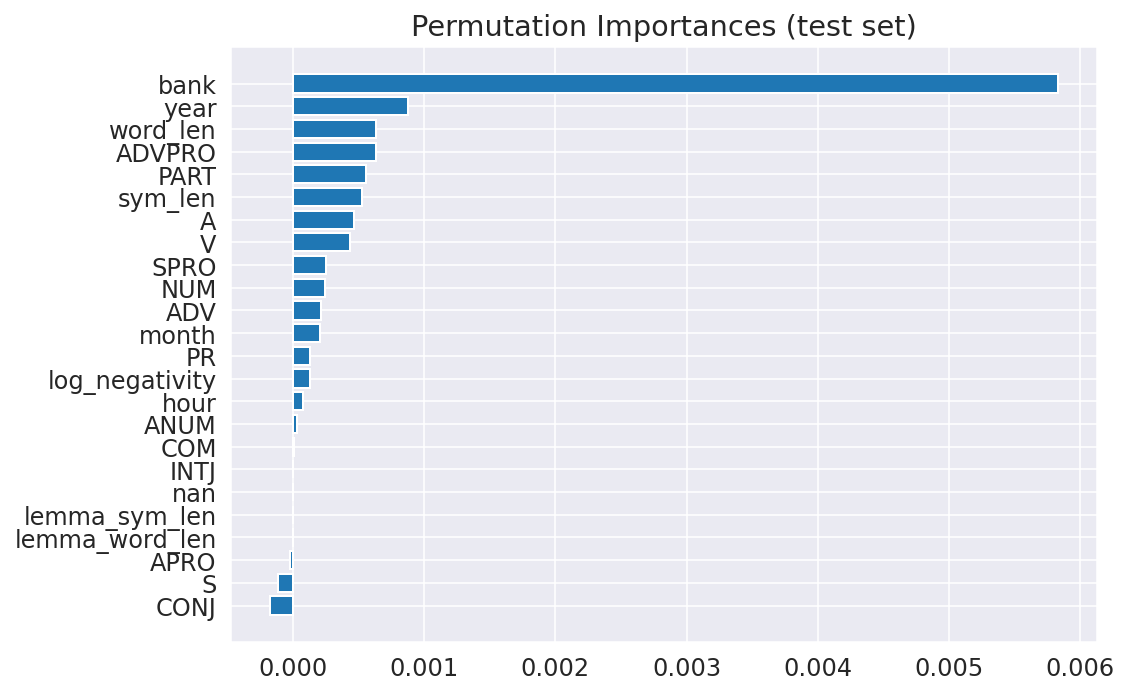

In [257]:
sorted_idx = result.importances_mean.argsort()[:-1]

fig, ax = plt.subplots()
ax.barh(X_val.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (val set)")
fig.tight_layout()
plt.show()

Если выкинуть из модели выше "month", "CONJ", "lemmaword_len", "lemma_sym_len", получится мой последний сабмишн, его же видно на валидации выше, пайплайн выводится, можно проверить. Если не выкидывать, получится модель, которая предсказывает "duality_of_ovr", он же прикрепился к датасету, я надеюсь?

Самые значимые слова достать уже сложнее. Я своровал этот код где-то со stackoverflow, но ссылку, как обычно не сохранил

In [ ]:
import sklearn


def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
feature_names = get_feature_names(pipe["preprocessor"])
coefs_with_fns = sorted(zip(pipe["classifier"].coef_[0], feature_names)) 
feature_importance = pd.DataFrame(coefs_with_fns, columns=["coef", "name"])
feature_importance["name"] = feature_importance.name.apply(lambda x: x.lstrip("vectorize__"))
most_important = feature_importance.sort_values(by="coef")
most_important = most_important[most_important["coef"] != 0]
samples = np.arange(5, len(most_important)+1, len(most_important)/25).astype(int)
sub_df = most_important.iloc[samples]

Это считается довольно долго, чтобы не считать, у меня в датасете лежит `feature_importance.csv`

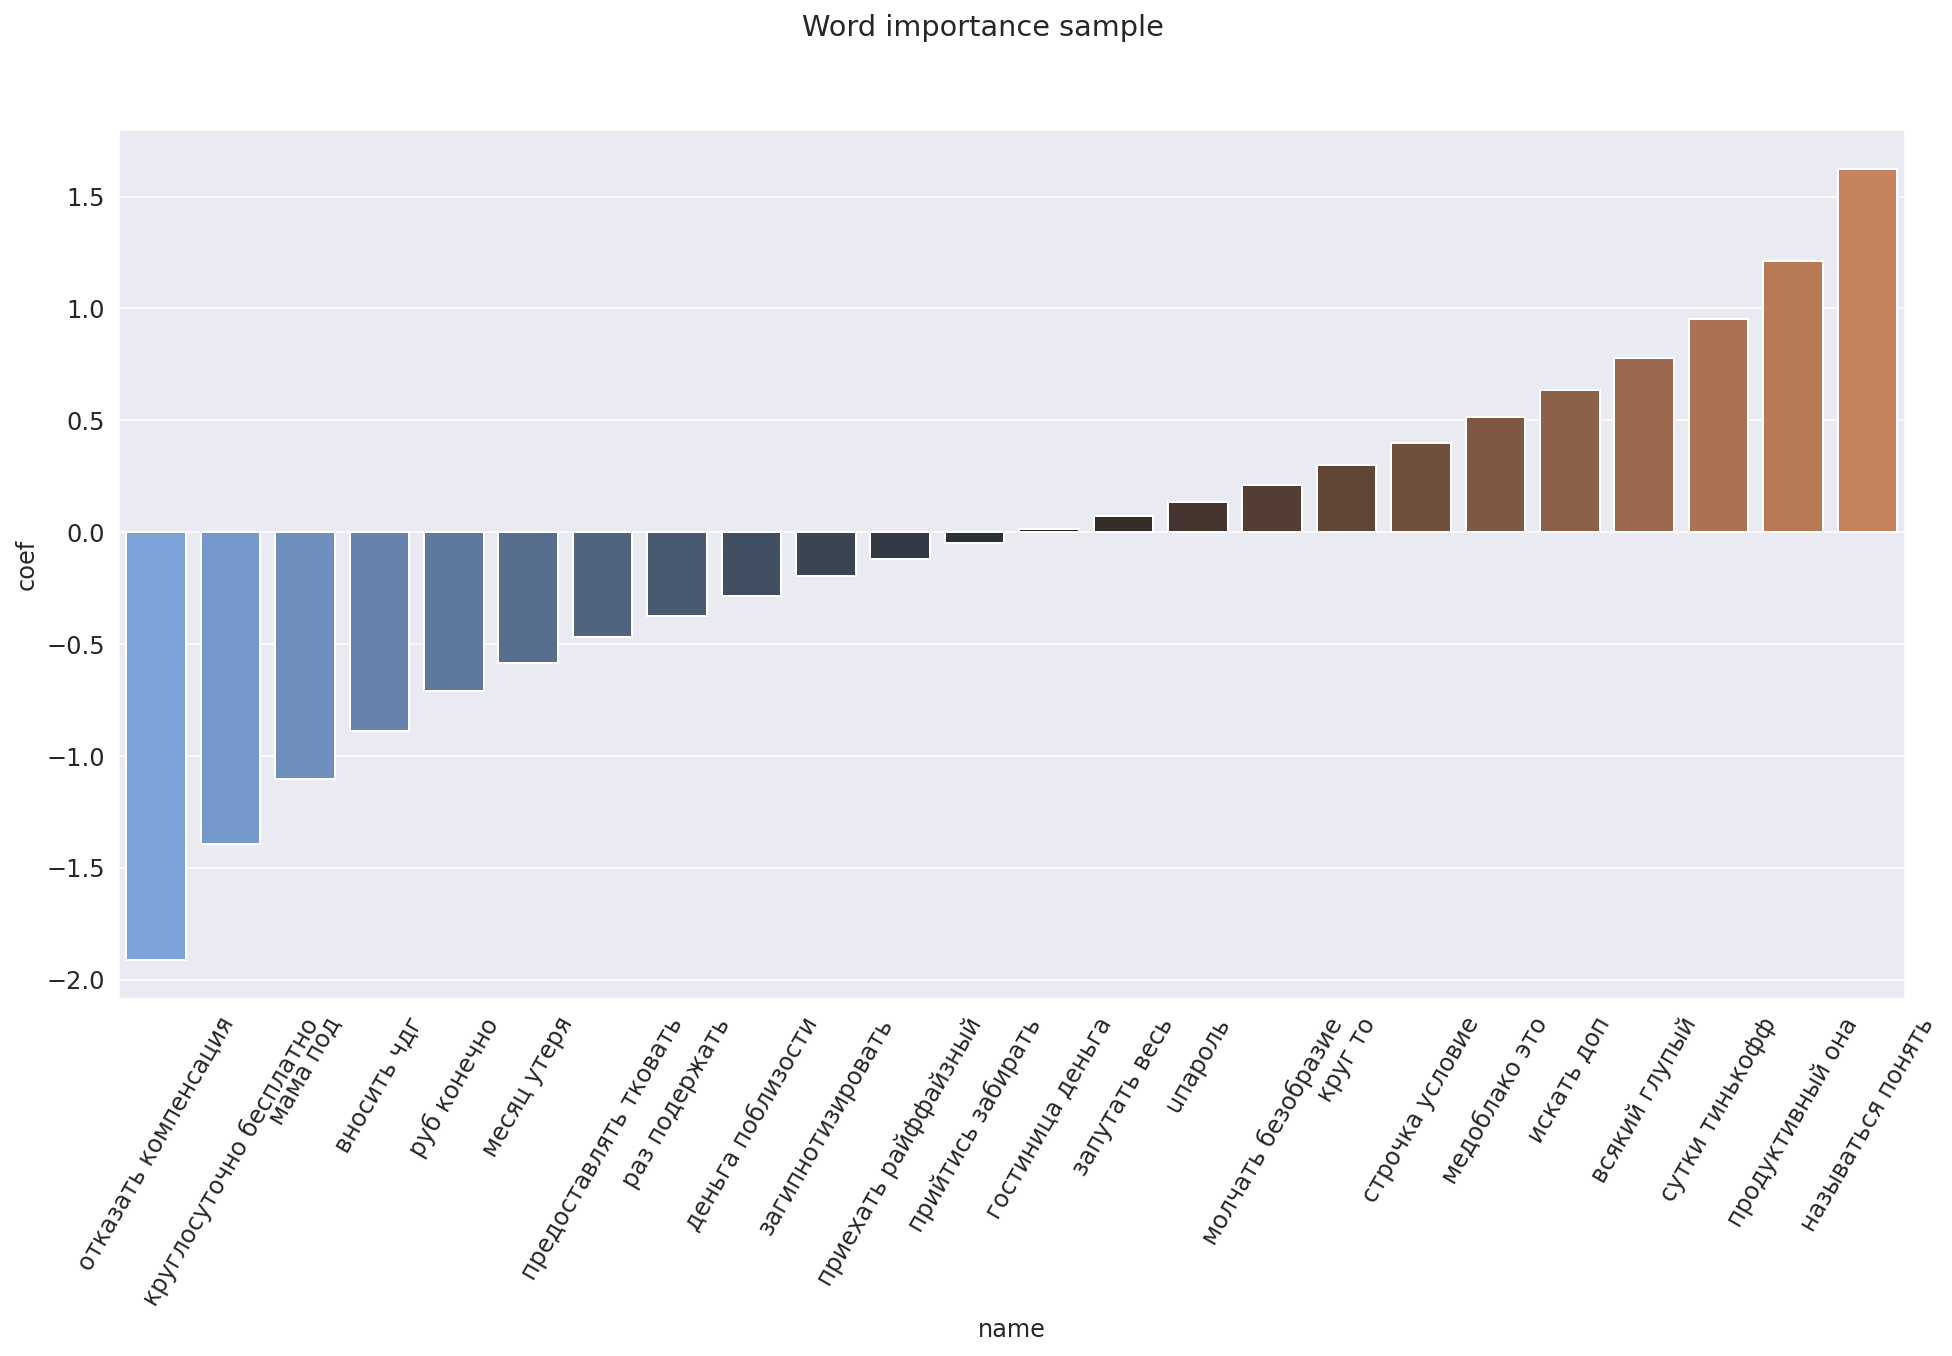

In [365]:
fig, _ = plt.subplots(figsize=(16, 8))

palette = sns.diverging_palette(250, 30, l=65, center="dark", n=25)
sns.barplot(x="name", y="coef", data=sub_df[1:], palette=palette)
plt.xticks(rotation=60)
plt.suptitle("Word importance sample")
plt.show()

Не сказать, что это нам многое говорит, но мы хотя бы видим, что самыми важными являются именно биграммы, ну и график красивый, само собой

И наконец функция, которой удобно доставать csv в нужном для соревнования формате. По ссылке, потому что из output'а на кеггле загружается через раз

Больше я ничего не делал, потому что я устал, ну правда... Что я ещё не пробовал:

1. Добавить предложения из другого объекта того же кластера. Вот это мне кажется гораздо оптимистичнее, по крайней мере новые такие объекты будут различаться довольно сильно, но есть риск испортить признаки, которые у нас что-то подсчитывают, тут придётся подбирать параметры, если это вообще полезно
3. Трансформировать длины. Я пытался их подправить логарифмом, но я делал это для всех фичей сразу. К сожалению, там около 16 комбинаций трансформированных-не трансформированных фичей, мне просто лень их все перебирать, возможно, качество улучшится
5. Посчитать расстояние между документами. Если я правильно помню, для этого по-хорошему нужно делать PCA и смотреть на косинусное расстояние в матрице документов. Даже если бы я мог это сделать (но я не могу - слишком нагруженная операция), у нас всё-таки не w2v модель и похожие документы не обязаны быть похожи семантически, но кто знает
6. InfoGain. Может быть поможет отфильтровать текстовые фичи лучше, чем KBest, не знаю - не тестил, меня и так всё устраивает
7. Исправить опечатки. Может помочь, а может и не помочь, вдруг это отражает, что человек был злой, когда это писал, поэтому отзыв негативный
8. Почистить от выбросов. Может помочь, но тогда придётся переподбирать гиперпараметры модели, плюс мы потеряем какую-никакую инфу, которую я бы лично терять не хотел